In [1]:
#relevant imports 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from PIL import Image
import os
from tqdm.auto import tqdm

from sklearn.model_selection import train_test_split, KFold
from skimage import io
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, roc_auc_score

import torch
from torch import nn
import torchvision
from torchvision import datasets, models, transforms as T
from torch.utils.data import Dataset, DataLoader, Subset, ConcatDataset
import torch.utils.data as data
import torchvision.utils as vutils
from torchinfo import summary
import torch.nn.functional as F

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Input processing and utilities

In [2]:
#reading the csv file and making column manipulations

fold_info = pd.read_csv("/kaggle/input/breakhis/Folds.csv") 
class_names = ['malignant', 'benign']
fold_info = fold_info.rename(columns={'filename': 'path'})
fold_info['label'] = fold_info.path.apply(lambda x: x.split('/')[3])
fold_info['label_int'] = fold_info.label.apply(lambda x: class_names.index(x))

In [3]:
fold_info

,fold,mag,grp,path,label,label_int
0,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...,benign,1
1,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...,benign,1
2,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...,benign,1
3,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...,benign,1
4,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...,benign,1
...,...,...,...,...,...,...
39540,5,400,test,BreaKHis_v1/histology_slides/breast/malignant/...,malignant,0
39541,5,400,test,BreaKHis_v1/histology_slides/breast/malignant/...,malignant,0
39542,5,400,test,BreaKHis_v1/histology_slides/breast/malignant/...,malignant,0
39543,5,400,test,BreaKHis_v1/histology_slides/breast/malignant/...,malignant,0


In [4]:
#creating test and train dfs according to 'grp'
train_df=fold_info[fold_info.grp=='train']
test_df=fold_info[fold_info.grp=='test']
test_df['path'] = ('/kaggle/input/breakhis/BreaKHis_v1/' + test_df['path'])

/tmp/ipykernel_1253/2481831445.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['path'] = ('/kaggle/input/breakhis/BreaKHis_v1/' + test_df['path'])


In [5]:
train_df

,fold,mag,grp,path,label,label_int
0,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...,benign,1
1,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...,benign,1
2,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...,benign,1
3,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...,benign,1
4,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...,benign,1
...,...,...,...,...,...,...
36457,5,400,train,BreaKHis_v1/histology_slides/breast/malignant/...,malignant,0
36458,5,400,train,BreaKHis_v1/histology_slides/breast/malignant/...,malignant,0
36459,5,400,train,BreaKHis_v1/histology_slides/breast/malignant/...,malignant,0
36460,5,400,train,BreaKHis_v1/histology_slides/breast/malignant/...,malignant,0


In [6]:
#split train dataset wrt fold numbers
fold_data = [group for _, group in train_df.groupby('fold')]
for i,_ in enumerate(fold_data):
    selected_fold=i+1
    fold_data[i]=fold_info.query("fold == @selected_fold").copy()
    fold_data[i]['path'] = ('/kaggle/input/breakhis/BreaKHis_v1/' + fold_data[i]['path'])


In [7]:
class CustomDataset(data.Dataset):
    '''
    Implementation of a custom dataset class.
    '''
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform

    def __getitem__(self, index):
        filename = self.df.iloc[index]['path']
        label = self.df.iloc[index]['label_int']
        img = Image.open(filename).convert('RGB')
        if self.transform:
            img = self.transform(img)
        return img, label

    def __len__(self):
        return len(self.df)

In [8]:
MEAN, STD=(0.5, 0.5, 0.5), (0.5, 0.5, 0.5)
IMAGE_SIZE=224
BATCH_SIZE=64

In [9]:
data_transforms = T.Compose([
    T.ToTensor(),
    T.Resize((IMAGE_SIZE, IMAGE_SIZE), antialias=True),
    T.Normalize(MEAN, STD)
])

In [10]:
#create separate datasets for all five folds
fold_datasets = []
for fold in fold_data:
#     fold=fold.sample(frac=1).reset_index(drop=True)
    dataset = CustomDataset(pd.concat([fold.iloc[:200], fold.iloc[-200:]]), transform=data_transforms)
    fold_datasets.append(dataset)
    
test_df = test_df.sample(frac=1).reset_index(drop=True)
test_set=CustomDataset(test_df[:400], transform=data_transforms)
test_loader=DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=True)

In [11]:
def plot_images(dataloader, num_images=16):
    """
    function for easy visualisation of images from dataset.
    args:
        dataloader: a pytorch dataloader object
        num_images: number of images to be plotted
    """
    
    # Get a batch of images from the dataloader
    data = next(iter(dataloader))
    images, _ = data

    # Generate a grid of images
    img_grid = vutils.make_grid(images[:num_images], nrow=4, padding=2, normalize=True)

    # Convert the image grid to a numpy array and transpose the dimensions
    img_grid = np.transpose(img_grid.cpu().numpy(), (1, 2, 0))

    # Plot the image grid
    plt.figure(figsize=(10,10))
    plt.axis("off")
    plt.imshow(img_grid)
    plt.title("Sample Images")
    plt.show()


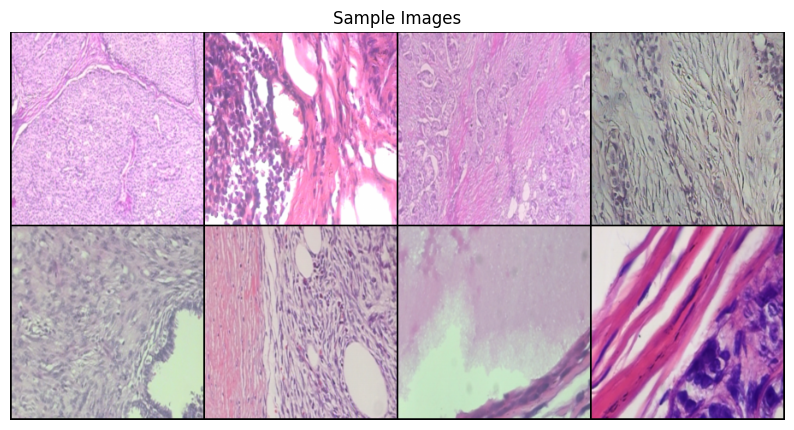

In [12]:
plot_images(test_loader, num_images=8)

# Model Classes

In [13]:
class ResNet18(nn.Module):
    '''
    Class to define a pretrained ResNet18 model. 
    '''
    def __init__(self):
        super().__init__()
        self.resnet18 = models.resnet18(pretrained=True)

    def forward(self, x):
        return self.resnet18(x)


In [14]:
class ShuffleNet(nn.Module):
    """
    Class to define a pretrained shufflenet model.
    """
    def __init__(self):
        super().__init__()
        self.shufflenet = models.shufflenet_v2_x1_0(pretrained=True)
        
    def forward(self, x):
        return self.shufflenet(x)


In [15]:
class VGG16(nn.Module):
    """
    Class to define a pretrained VGG16 model
    """
    def __init__(self):
        super().__init__()
        self.vgg16 = models.vgg16(pretrained=True)

    def forward(self, x):
        return self.vgg16(x)


In [16]:
class MobileNetV2(nn.Module):
    """
    Class to define a pretrained MobileNetV2 model
    """
    def __init__(self):
        super().__init__()
        self.mobilenetv2 = models.mobilenet_v2(pretrained=True)

    def forward(self, x):
        return self.mobilenetv2(x)



In [17]:
class AlexNet(nn.Module):
    """
    Class to define a pretrained AlexNet model
    """
    def __init__(self):
        super().__init__()
        self.alexnet = models.alexnet(pretrained=True)

    def forward(self, x):
        return self.alexnet(x)


# Training and adjacent functions

In [18]:
B=0.05 #threshold value to determine the activation of second model

def weight_factor(class_prob):
    """
    function to calculate weight factor as defined in the paper.
    args:
        class_prob: pytorch tensor with dims [batch_size, 2]
    """
    p1 = class_prob[:, 0]
    p2 = class_prob[:, 1]
    w = torch.abs(torch.mul(p1, torch.log2(2 * p2)) + torch.mul(p2, torch.log2(2 * p1)))
    return w

In [19]:
def reset_weights(m):
    """
    reset model weights to prevent weight leakage
    """
    for layer in m.children():
        if hasattr(layer, 'reset_parameters'):
            layer.reset_parameters()



In [20]:
def train_step(model: nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device: torch.device
              ):
    """
    One epoch of training.
    Args:
        model: the pytorch model to be trained
        dataloader: pytorch DataLoader object to train the model on
        loss_fn: pytorch loss function
        optimizer: pytorch optimizer function to minimise loss
        device: gpu/cpu
    
    Returns:
        train_loss
        train_acc
    """
    
    model.train()
    train_loss, train_acc=0,0
    
    for batch, (X,y) in enumerate(dataloader):
        
        X,y = X.to(device), y.to(device)
        
        y_pred=model(X)
        
        loss=loss_fn(y_pred, y)
        train_loss +=loss.item()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)
    
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc
    

In [21]:
def valid_step(model: torch.nn.Module, 
               optimizer: torch.optim.Optimizer,
               loss_fn: torch.nn.Module,
               device: torch.device,
              valid_set) :
    """
    One epoch of validation.
    Args:
        model: the pytorch model to be tested
        optimizer: pytorch optimizer to minimize loss
        loss_fn: pytorch loss function
        device: gpu/cpu
        valid_set: validation dataset
    
    Return:
        valid_loss
        valid_acc
        final_subset: subset of samples not clearing classification criteria of first model, to be sent to second model
        weights : weight factor values of the aforementioned samples
        precision
        recall
        auc
        f1
        specificity
    """
    dataloader = DataLoader(valid_set, batch_size = BATCH_SIZE, shuffle=True)
    # Put model in eval mode
    model.eval() 

    # Setup test loss and test accuracy values
    valid_loss, valid_acc, recall, precision, specificity, f1, auc = 0, 0, 0, 0, 0, 0 ,0

    #Create lists to store indices for subset creation
    selected_batch_indices = []
    selected_sample_indices = []

    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            valid_pred_logits = model(X)

            #get class probabilities and subsequently weight factor
            class_prob=F.softmax(valid_pred_logits, dim=1)
            weights=weight_factor(class_prob)
            
            #sending logits to cpu for metrics calculation
            y_cpu=y.detach().cpu().numpy()
            y_pred_cpu=valid_pred_logits.detach().cpu().numpy()
            y_pred_bin = np.argmax(y_pred_cpu, axis=1)
            

            #store indices of images with weight factor less than threshold to access labels
            selected_sample_indices_batch = [i for i, w in enumerate(weights) if w < B]
            selected_batch_indices += [batch] * len(selected_sample_indices_batch)
            selected_sample_indices += selected_sample_indices_batch
            # 2. Calculate and accumulate loss
            loss = loss_fn(valid_pred_logits, y)
            valid_loss += loss.item()


            # Calculate and accumulate accuracy
            valid_pred_labels = valid_pred_logits.argmax(dim=1)
            valid_acc += ((valid_pred_labels == y).sum().item()/len(valid_pred_labels))
            
            #calculation of metrics
            precision+=precision_score(y_cpu, y_pred_bin)
            recall+=recall_score(y_cpu, y_pred_bin)
            f1+=f1_score(y_cpu, y_pred_bin)
            try:
                auc+=roc_auc_score(y_cpu, y_pred_bin)
            except ValueError:
                auc+=1
            specificity+=recall_score(y_cpu, y_pred_bin, pos_label=0)


    #create a subset of the relevant images and add their labels
    selected_indices = [i * BATCH_SIZE + j for i, j in zip(selected_batch_indices, selected_sample_indices)]
    final_subset = Subset(valid_set, selected_indices)
    
    #get avg metrics
    
    valid_loss = valid_loss / len(dataloader)
    valid_acc = valid_acc / len(dataloader)
    precision=precision/len(dataloader)*100 #percentage
    recall=recall/len(dataloader)*100 #percentage
    auc=auc/len(dataloader)
    f1=f1/len(dataloader)
    specificity=specificity/len(dataloader)*100 #percentage


    return valid_loss, valid_acc, final_subset, weights, precision, recall, auc, f1, specificity


In [43]:
def kfold_step(model: torch.nn.Module,
              train_dataloader: torch.utils.data.DataLoader,
              optimizer: torch.optim.Optimizer,
              loss_fn: torch.nn.Module,
              epochs:int,
              device: torch.device,
              results: dict,
              valid_set):
    """
    One fold of k-fold cross validation, consists of n epochs of training and then validation.
    Args:
        model: the pytorch model to be tested
        train_dataloader: pytorch DataLoader object to train the model on
        optimizer: pytorch optimizer to minimize loss
        loss_fn: pytorch loss function
        device: gpu/cpu
        epochs: number of epochs
        val_set: validation dataset
        
    Return:
        final_subset
        weights
    
    """
    model.apply(reset_weights)
    model.to(device)
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model = model,
                                          dataloader = train_dataloader,
                                          loss_fn = loss_fn ,
                                          optimizer = optimizer,
                                          device = device)
        print(
            f"Epoch: {epoch+1} |"
            f"train_loss: {train_loss:.4f} | "
            f"train_acc %: {train_acc*100:.2f} | ")
        
    print("Training complete, validation begins")
    valid_loss, valid_acc, final_subset, weights, precision, recall, auc, f1, specificity = valid_step(model = model,
                                                                                                       valid_set=valid_set,
                                                                                                       optimizer = optimizer,
                                                                                                       loss_fn = loss_fn,
                                                                                                       device = device )
        
    print(
        f"valid_loss: {valid_loss:.4f} | "
        f"valid_acc %: {valid_acc*100:.2f}  "
        f"precision %: {precision:.2f} | "
        f"recall %: {recall: .2f} | "
        f"auc : {auc :.4f} | "
        f"specificity %: {specificity:.2f} | "
        f"f1: {f1:.4f} "
        )
    
#     model.apply(reset_weights)
        
    results["valid_loss"].append(valid_loss)
    results["valid_acc"].append(valid_acc)
    results["precision"].append(precision)
    results["recall"].append(recall)
    results["auc"].append(auc)
    results["specificity"].append(specificity)
    results["f1"].append(f1)

    return final_subset, weights

In [44]:
def kfold_pipeline(m1: torch.nn.Module,
                 opt1: torch.optim.Optimizer,
                 m2: torch.nn.Module,
                 opt2: torch.optim.Optimizer,
                 loss_fn: torch.nn.Module,
                 epochs: int,
                 device: torch.device,
                 train_dataloader: torch.utils.data.DataLoader,
                   m1_results: dict,
                   m2_results: dict,
                   valid_set
                ):
    """
    STEPS:
    - train model 1 on 4 folds for 12 epochs
    - validate model 1 on 5th fold
    - get subset
    - train model 2 on 4 folds for 12 epochs
    - validate model 2 on subset
    
    Args:
        m1: first model for hybrid
        opt1: optimizer for first model
        m2: second model for hybrid
        opt2: optimizer for second model
        loss_fn: loss function
        epochs: number of epochs
        device: cpu/gpu
        train_dataloader: train dataloader (made from k-1 concatenated datasets)
        m1_results: dict to store first model results
        m2_results: dict to store second model results
        valid_set: validation dataset
    """
    
    act=False
    
    final_subset, weights=kfold_step(model=m1,
                                     train_dataloader=train_dataloader,
                                     valid_set=valid_set,
                                     optimizer=opt1,
                                     loss_fn=loss_fn,
                                     epochs=epochs,
                                     device=device,
                                     results=m1_results
                                    )
    
    if (len(final_subset)>0):
        act=True
        print("Hybrid Model activated")
        subset, w = kfold_step(model=m2,
                              train_dataloader=train_dataloader,
                              valid_set=final_subset,
                               optimizer=opt2,
                               loss_fn=loss_fn,
                               epochs=epochs,
                               device=device,
                               results=m2_results
                              )
        
    else:
        print("Hybrid model not activated due to first model giving satisfactory results")

    
    return act

In [45]:
def train(m1: torch.nn.Module,
          m2: torch.nn.Module,
          opt1: torch.optim.Optimizer,
          opt2: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device,
          m1_results: dict,
          m2_results: dict,
          fold_datasets: list):
    """
    Function to train one whole hybrid model. Second model activated only if first model does not meet classification criteria for all samples.
    
     Args:
        m1: first model for hybrid
        opt1: optimizer for first model
        m2: second model for hybrid
        opt2: optimizer for second model
        loss_fn: loss function
        epochs: number of epochs
        device: cpu/gpu
        m1_results: dict to store first model results
        m2_results: dict to store second model results
        fold_datasets: list of all k datasets (5 in this case)
    """
    
    m1.to(device)
    m2.to(device)
    activated=0
    
    for i, val_set in enumerate(fold_datasets):
        print(f"-------- Fold {i+1} results --------")
        train_sets = [d for j, d in enumerate(fold_datasets) if j != i]
        fold_train_set = ConcatDataset(train_sets)
        train_loader = DataLoader(fold_train_set, batch_size = BATCH_SIZE, shuffle=True)
        
        act= kfold_pipeline(m1=m1,
                           opt1=opt1,
                           m2=m2,
                           opt2=opt2,
                           loss_fn=loss_fn,
                           epochs=epochs,
                           device=device,
                           train_dataloader=train_loader,
                           valid_set=val_set,
                           m1_results=m1_results,
                           m2_results=m2_results)
        if (act==True): 
            activated+=1
            
    avg_results = {}
    print("average results across 5 folds: ")
    if (activated>=1):
        for k, v in m2_results.items() :
            avg_results[k] = sum(v) / len(v) 
    else:
        for k, v in m1_results.items() :
            avg_results[k] = sum(v) / len(v)
    print(avg_results)
    
        

In [25]:
device ='cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

# Hybrid-1: MobileNet + ResNet

In [26]:
mobilenet_h1 = MobileNetV2()

mobilenet_h1_opt=torch.optim.Adam(params=mobilenet_h1.parameters(),
                                 lr=1e-4)

resnet_h1 = ResNet18()

resnet_h1_opt=torch.optim.Adam(params=resnet_h1.parameters(),
                              lr=1e-4)



/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-d

In [27]:
mobilenet_h1_results = { "valid_loss": [],
              "valid_acc": [],
              "precision": [],
              "recall": [],
              "auc": [],
              "specificity": [],
              "f1": []}

resnet_h1_results = { "valid_loss": [],
              "valid_acc": [],
              "precision": [],
              "recall": [],
              "auc": [],
              "specificity": [],
              "f1": []}
    

In [28]:
train(m1= mobilenet_h1,
     m2= resnet_h1,
     opt1 = mobilenet_h1_opt,
     opt2=resnet_h1_opt,
     loss_fn= F.cross_entropy,
     epochs= 12,
     device=device,
     m1_results=mobilenet_h1_results,
     m2_results=resnet_h1_results,
     fold_datasets= fold_datasets)



-------- Fold 1 results --------


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch: 1 |train_loss: 3.9707 | train_acc %: 51.31 | 
Epoch: 2 |train_loss: 0.1228 | train_acc %: 98.69 | 
Epoch: 3 |train_loss: 0.0173 | train_acc %: 99.88 | 
Epoch: 4 |train_loss: 0.0035 | train_acc %: 100.00 | 
Epoch: 5 |train_loss: 0.0084 | train_acc %: 99.81 | 
Epoch: 6 |train_loss: 0.0076 | train_acc %: 99.81 | 
Epoch: 7 |train_loss: 0.0070 | train_acc %: 99.75 | 
Epoch: 8 |train_loss: 0.0056 | train_acc %: 99.88 | 
Epoch: 9 |train_loss: 0.0036 | train_acc %: 99.94 | 
Epoch: 10 |train_loss: 0.0124 | train_acc %: 99.69 | 
Epoch: 11 |train_loss: 0.0060 | train_acc %: 99.88 | 
Epoch: 12 |train_loss: 0.0053 | train_acc %: 99.81 | 
Training complete, validation begins
valid_loss: 0.0004 | valid_acc %: 100.00  precision %: 100.00 | recall %:  100.00 | auc : 1.0000 | specificity %: 100.00 | f1: 1.0000 
Hybrid model not activated due to first model giving satisfactory results
-------- Fold 2 results --------


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch: 1 |train_loss: 4.7001 | train_acc %: 52.69 | 
Epoch: 2 |train_loss: 0.9061 | train_acc %: 82.31 | 
Epoch: 3 |train_loss: 0.2007 | train_acc %: 95.12 | 
Epoch: 4 |train_loss: 0.1226 | train_acc %: 97.06 | 
Epoch: 5 |train_loss: 0.0911 | train_acc %: 97.25 | 
Epoch: 6 |train_loss: 0.0533 | train_acc %: 99.00 | 
Epoch: 7 |train_loss: 0.0459 | train_acc %: 98.88 | 
Epoch: 8 |train_loss: 0.0328 | train_acc %: 99.50 | 
Epoch: 9 |train_loss: 0.0264 | train_acc %: 99.38 | 
Epoch: 10 |train_loss: 0.0228 | train_acc %: 99.69 | 
Epoch: 11 |train_loss: 0.0117 | train_acc %: 100.00 | 
Epoch: 12 |train_loss: 0.0256 | train_acc %: 99.50 | 
Training complete, validation begins
valid_loss: 0.0090 | valid_acc %: 100.00  precision %: 100.00 | recall %:  100.00 | auc : 1.0000 | specificity %: 100.00 | f1: 1.0000 
Hybrid model not activated due to first model giving satisfactory results
-------- Fold 3 results --------


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch: 1 |train_loss: 4.4705 | train_acc %: 56.12 | 
Epoch: 2 |train_loss: 0.6753 | train_acc %: 87.25 | 
Epoch: 3 |train_loss: 0.1525 | train_acc %: 95.62 | 
Epoch: 4 |train_loss: 0.0764 | train_acc %: 98.12 | 
Epoch: 5 |train_loss: 0.0405 | train_acc %: 99.38 | 
Epoch: 6 |train_loss: 0.0288 | train_acc %: 99.62 | 
Epoch: 7 |train_loss: 0.0182 | train_acc %: 99.75 | 
Epoch: 8 |train_loss: 0.0152 | train_acc %: 99.81 | 
Epoch: 9 |train_loss: 0.0148 | train_acc %: 99.75 | 
Epoch: 10 |train_loss: 0.0119 | train_acc %: 99.81 | 
Epoch: 11 |train_loss: 0.0200 | train_acc %: 99.62 | 
Epoch: 12 |train_loss: 0.0083 | train_acc %: 100.00 | 
Training complete, validation begins
valid_loss: 1.8178 | valid_acc %: 73.66  precision %: 66.44 | recall %:  100.00 | auc : 0.7305 | specificity %: 46.10 | f1: 0.7947 
Hybrid model not activated due to first model giving satisfactory results
-------- Fold 4 results --------


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch: 1 |train_loss: 4.3161 | train_acc %: 58.31 | 
Epoch: 2 |train_loss: 0.6987 | train_acc %: 84.69 | 
Epoch: 3 |train_loss: 0.2075 | train_acc %: 92.94 | 
Epoch: 4 |train_loss: 0.1149 | train_acc %: 96.81 | 
Epoch: 5 |train_loss: 0.0598 | train_acc %: 98.50 | 
Epoch: 6 |train_loss: 0.0472 | train_acc %: 98.69 | 
Epoch: 7 |train_loss: 0.0567 | train_acc %: 98.25 | 
Epoch: 8 |train_loss: 0.0335 | train_acc %: 99.06 | 
Epoch: 9 |train_loss: 0.0255 | train_acc %: 99.38 | 
Epoch: 10 |train_loss: 0.0096 | train_acc %: 100.00 | 
Epoch: 11 |train_loss: 0.0231 | train_acc %: 99.44 | 
Epoch: 12 |train_loss: 0.0138 | train_acc %: 99.69 | 
Training complete, validation begins
valid_loss: 0.0036 | valid_acc %: 100.00  precision %: 100.00 | recall %:  100.00 | auc : 1.0000 | specificity %: 100.00 | f1: 1.0000 
Hybrid model not activated due to first model giving satisfactory results
-------- Fold 5 results --------


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch: 1 |train_loss: 4.4032 | train_acc %: 53.31 | 
Epoch: 2 |train_loss: 0.5535 | train_acc %: 87.94 | 
Epoch: 3 |train_loss: 0.1706 | train_acc %: 94.88 | 
Epoch: 4 |train_loss: 0.1065 | train_acc %: 96.81 | 
Epoch: 5 |train_loss: 0.0711 | train_acc %: 98.06 | 
Epoch: 6 |train_loss: 0.0532 | train_acc %: 98.56 | 
Epoch: 7 |train_loss: 0.0488 | train_acc %: 98.75 | 
Epoch: 8 |train_loss: 0.0300 | train_acc %: 99.31 | 
Epoch: 9 |train_loss: 0.0230 | train_acc %: 99.38 | 
Epoch: 10 |train_loss: 0.0235 | train_acc %: 99.31 | 
Epoch: 11 |train_loss: 0.0169 | train_acc %: 99.69 | 
Epoch: 12 |train_loss: 0.0175 | train_acc %: 99.50 | 
Training complete, validation begins
valid_loss: 0.0049 | valid_acc %: 100.00  precision %: 100.00 | recall %:  100.00 | auc : 1.0000 | specificity %: 100.00 | f1: 1.0000 
Hybrid model not activated due to first model giving satisfactory results
average results across 5 folds: 
{'valid_loss': 0.3671403413149944, 'valid_acc': 0.9473214285714284, 'precision': 9

# Hybrid 2 : VGG16 + ResNet18

In [46]:
vgg_h2=VGG16()

vgg_h2_opt =  torch.optim.Adam(params = vgg_h2.parameters(),
                               lr=1e-4)

resnet_h2 = ResNet18()

resnet_h2_opt=torch.optim.Adam(params=resnet_h2.parameters(),
                              lr=1e-4)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
 

In [47]:
vgg_h2_results = { "valid_loss": [],
              "valid_acc": [],
              "precision": [],
              "recall": [],
              "auc": [],
              "specificity": [],
              "f1": []}

resnet_h2_results = { "valid_loss": [],
              "valid_acc": [],
              "precision": [],
              "recall": [],
              "auc": [],
              "specificity": [],
              "f1": []}
    

In [49]:
train(m1= vgg_h2,
     m2= resnet_h2,
     opt1 = vgg_h2_opt,
     opt2=resnet_h2_opt,
     loss_fn= F.cross_entropy,
     epochs= 12,
     device=device,
     m1_results=vgg_h2_results,
     m2_results=resnet_h2_results,
     fold_datasets= fold_datasets)



-------- Fold 1 results --------


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch: 1 |train_loss: 2.6442 | train_acc %: 46.62 | 
Epoch: 2 |train_loss: 0.7402 | train_acc %: 50.44 | 
Epoch: 3 |train_loss: 0.7131 | train_acc %: 51.62 | 
Epoch: 4 |train_loss: 0.7121 | train_acc %: 50.50 | 
Epoch: 5 |train_loss: 0.7025 | train_acc %: 50.44 | 
Epoch: 6 |train_loss: 0.7212 | train_acc %: 47.94 | 
Epoch: 7 |train_loss: 0.7210 | train_acc %: 48.00 | 
Epoch: 8 |train_loss: 0.7046 | train_acc %: 48.50 | 
Epoch: 9 |train_loss: 0.7138 | train_acc %: 48.88 | 
Epoch: 10 |train_loss: 0.7140 | train_acc %: 49.69 | 
Epoch: 11 |train_loss: 0.7056 | train_acc %: 50.75 | 
Epoch: 12 |train_loss: 0.7105 | train_acc %: 48.50 | 
Training complete, validation begins
valid_loss: 0.6951 | valid_acc %: 50.67  precision %: 50.67 | recall %:  100.00 | auc : 0.5000 | specificity %: 0.00 | f1: 0.6715 
Hybrid Model activated


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch: 1 |train_loss: 1.8768 | train_acc %: 80.06 | 
Epoch: 2 |train_loss: 0.2381 | train_acc %: 94.50 | 
Epoch: 3 |train_loss: 0.1316 | train_acc %: 95.88 | 
Epoch: 4 |train_loss: 0.1349 | train_acc %: 95.81 | 
Epoch: 5 |train_loss: 0.1333 | train_acc %: 96.12 | 
Epoch: 6 |train_loss: 0.1218 | train_acc %: 96.06 | 
Epoch: 7 |train_loss: 0.0633 | train_acc %: 97.56 | 
Epoch: 8 |train_loss: 0.0438 | train_acc %: 98.81 | 
Epoch: 9 |train_loss: 0.0571 | train_acc %: 97.75 | 
Epoch: 10 |train_loss: 0.0665 | train_acc %: 97.94 | 
Epoch: 11 |train_loss: 0.0632 | train_acc %: 97.94 | 
Epoch: 12 |train_loss: 0.0431 | train_acc %: 98.69 | 
Training complete, validation begins
valid_loss: 0.0121 | valid_acc %: 99.78  precision %: 99.55 | recall %:  100.00 | auc : 0.9978 | specificity %: 99.57 | f1: 0.9977 
-------- Fold 2 results --------


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch: 1 |train_loss: 2.4332 | train_acc %: 45.75 | 
Epoch: 2 |train_loss: 0.7329 | train_acc %: 49.44 | 
Epoch: 3 |train_loss: 0.7089 | train_acc %: 48.50 | 
Epoch: 4 |train_loss: 0.7052 | train_acc %: 48.25 | 
Epoch: 5 |train_loss: 0.7003 | train_acc %: 51.31 | 
Epoch: 6 |train_loss: 0.6995 | train_acc %: 48.81 | 
Epoch: 7 |train_loss: 0.7011 | train_acc %: 50.06 | 
Epoch: 8 |train_loss: 0.7012 | train_acc %: 49.06 | 
Epoch: 9 |train_loss: 0.7037 | train_acc %: 49.25 | 
Epoch: 10 |train_loss: 0.7023 | train_acc %: 50.94 | 
Epoch: 11 |train_loss: 0.6977 | train_acc %: 51.06 | 
Epoch: 12 |train_loss: 0.7057 | train_acc %: 48.50 | 
Training complete, validation begins


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defin

valid_loss: 0.6967 | valid_acc %: 50.67  precision %: 0.00 | recall %:  0.00 | auc : 0.5000 | specificity %: 100.00 | f1: 0.0000 
Hybrid Model activated


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch: 1 |train_loss: 1.8150 | train_acc %: 81.44 | 
Epoch: 2 |train_loss: 0.1981 | train_acc %: 94.44 | 
Epoch: 3 |train_loss: 0.1410 | train_acc %: 95.94 | 
Epoch: 4 |train_loss: 0.1146 | train_acc %: 96.19 | 
Epoch: 5 |train_loss: 0.0892 | train_acc %: 97.12 | 
Epoch: 6 |train_loss: 0.0913 | train_acc %: 96.75 | 
Epoch: 7 |train_loss: 0.1021 | train_acc %: 96.69 | 
Epoch: 8 |train_loss: 0.0670 | train_acc %: 97.88 | 
Epoch: 9 |train_loss: 0.1065 | train_acc %: 96.38 | 
Epoch: 10 |train_loss: 0.0572 | train_acc %: 98.00 | 
Epoch: 11 |train_loss: 0.0720 | train_acc %: 97.25 | 
Epoch: 12 |train_loss: 0.0722 | train_acc %: 97.31 | 
Training complete, validation begins
valid_loss: 0.3405 | valid_acc %: 88.62  precision %: 80.72 | recall %:  100.00 | auc : 0.8872 | specificity %: 77.43 | f1: 0.8923 
-------- Fold 3 results --------


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch: 1 |train_loss: 2.2289 | train_acc %: 47.31 | 
Epoch: 2 |train_loss: 0.7248 | train_acc %: 46.81 | 
Epoch: 3 |train_loss: 0.6992 | train_acc %: 50.50 | 
Epoch: 4 |train_loss: 0.7049 | train_acc %: 48.38 | 
Epoch: 5 |train_loss: 0.7037 | train_acc %: 49.19 | 
Epoch: 6 |train_loss: 0.7032 | train_acc %: 48.50 | 
Epoch: 7 |train_loss: 0.6997 | train_acc %: 49.00 | 
Epoch: 8 |train_loss: 0.7022 | train_acc %: 49.31 | 
Epoch: 9 |train_loss: 0.6997 | train_acc %: 50.06 | 
Epoch: 10 |train_loss: 0.7041 | train_acc %: 49.38 | 
Epoch: 11 |train_loss: 0.7013 | train_acc %: 50.19 | 
Epoch: 12 |train_loss: 0.7053 | train_acc %: 48.50 | 
Training complete, validation begins
valid_loss: 0.6943 | valid_acc %: 48.66  precision %: 48.66 | recall %:  100.00 | auc : 0.5000 | specificity %: 0.00 | f1: 0.6527 
Hybrid Model activated


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch: 1 |train_loss: 1.2829 | train_acc %: 85.75 | 
Epoch: 2 |train_loss: 0.2132 | train_acc %: 93.69 | 
Epoch: 3 |train_loss: 0.1381 | train_acc %: 95.69 | 
Epoch: 4 |train_loss: 0.1208 | train_acc %: 95.50 | 
Epoch: 5 |train_loss: 0.0800 | train_acc %: 97.00 | 
Epoch: 6 |train_loss: 0.0748 | train_acc %: 96.75 | 
Epoch: 7 |train_loss: 0.0477 | train_acc %: 97.75 | 
Epoch: 8 |train_loss: 0.0672 | train_acc %: 97.69 | 
Epoch: 9 |train_loss: 0.0628 | train_acc %: 97.81 | 
Epoch: 10 |train_loss: 0.0373 | train_acc %: 98.50 | 
Epoch: 11 |train_loss: 0.0516 | train_acc %: 98.06 | 
Epoch: 12 |train_loss: 0.0375 | train_acc %: 98.56 | 
Training complete, validation begins
valid_loss: 0.3205 | valid_acc %: 92.86  precision %: 92.49 | recall %:  93.16 | auc : 0.9285 | specificity %: 92.53 | f1: 0.9271 
-------- Fold 4 results --------


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch: 1 |train_loss: 2.3854 | train_acc %: 48.50 | 
Epoch: 2 |train_loss: 0.7287 | train_acc %: 50.31 | 
Epoch: 3 |train_loss: 0.7040 | train_acc %: 48.94 | 
Epoch: 4 |train_loss: 0.7011 | train_acc %: 49.88 | 
Epoch: 5 |train_loss: 0.7041 | train_acc %: 49.62 | 
Epoch: 6 |train_loss: 0.6988 | train_acc %: 50.25 | 
Epoch: 7 |train_loss: 0.6999 | train_acc %: 50.38 | 
Epoch: 8 |train_loss: 0.7001 | train_acc %: 48.75 | 
Epoch: 9 |train_loss: 0.7098 | train_acc %: 47.81 | 
Epoch: 10 |train_loss: 0.6960 | train_acc %: 51.38 | 
Epoch: 11 |train_loss: 0.7030 | train_acc %: 48.69 | 
Epoch: 12 |train_loss: 0.7021 | train_acc %: 48.31 | 
Training complete, validation begins


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defin

valid_loss: 0.6932 | valid_acc %: 53.35  precision %: 0.00 | recall %:  0.00 | auc : 0.5000 | specificity %: 100.00 | f1: 0.0000 
Hybrid Model activated


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch: 1 |train_loss: 1.5346 | train_acc %: 83.75 | 
Epoch: 2 |train_loss: 0.2397 | train_acc %: 93.88 | 
Epoch: 3 |train_loss: 0.1834 | train_acc %: 94.44 | 
Epoch: 4 |train_loss: 0.1019 | train_acc %: 96.50 | 
Epoch: 5 |train_loss: 0.0947 | train_acc %: 96.50 | 
Epoch: 6 |train_loss: 0.1279 | train_acc %: 96.19 | 
Epoch: 7 |train_loss: 0.0572 | train_acc %: 97.69 | 
Epoch: 8 |train_loss: 0.0579 | train_acc %: 97.44 | 
Epoch: 9 |train_loss: 0.0544 | train_acc %: 98.31 | 
Epoch: 10 |train_loss: 0.0668 | train_acc %: 97.19 | 
Epoch: 11 |train_loss: 0.0497 | train_acc %: 97.94 | 
Epoch: 12 |train_loss: 0.0461 | train_acc %: 98.38 | 
Training complete, validation begins
valid_loss: 0.0850 | valid_acc %: 96.43  precision %: 93.55 | recall %:  99.45 | auc : 0.9650 | specificity %: 93.55 | f1: 0.9634 
-------- Fold 5 results --------


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch: 1 |train_loss: 2.3157 | train_acc %: 49.00 | 
Epoch: 2 |train_loss: 0.7207 | train_acc %: 48.31 | 
Epoch: 3 |train_loss: 0.7098 | train_acc %: 49.19 | 
Epoch: 4 |train_loss: 0.7020 | train_acc %: 50.88 | 
Epoch: 5 |train_loss: 0.7101 | train_acc %: 50.31 | 
Epoch: 6 |train_loss: 0.7051 | train_acc %: 49.56 | 
Epoch: 7 |train_loss: 0.7082 | train_acc %: 50.31 | 
Epoch: 8 |train_loss: 0.7059 | train_acc %: 48.56 | 
Epoch: 9 |train_loss: 0.6983 | train_acc %: 50.44 | 
Epoch: 10 |train_loss: 0.7022 | train_acc %: 49.62 | 
Epoch: 11 |train_loss: 0.6990 | train_acc %: 51.62 | 
Epoch: 12 |train_loss: 0.7077 | train_acc %: 47.50 | 
Training complete, validation begins


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defin

valid_loss: 0.6942 | valid_acc %: 52.01  precision %: 0.00 | recall %:  0.00 | auc : 0.5000 | specificity %: 100.00 | f1: 0.0000 
Hybrid Model activated


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch: 1 |train_loss: 1.6486 | train_acc %: 82.88 | 
Epoch: 2 |train_loss: 0.2377 | train_acc %: 92.94 | 
Epoch: 3 |train_loss: 0.1879 | train_acc %: 94.94 | 
Epoch: 4 |train_loss: 0.1319 | train_acc %: 95.12 | 
Epoch: 5 |train_loss: 0.0971 | train_acc %: 96.88 | 
Epoch: 6 |train_loss: 0.0970 | train_acc %: 96.75 | 
Epoch: 7 |train_loss: 0.0661 | train_acc %: 97.81 | 
Epoch: 8 |train_loss: 0.0738 | train_acc %: 97.25 | 
Epoch: 9 |train_loss: 0.0698 | train_acc %: 97.50 | 
Epoch: 10 |train_loss: 0.0571 | train_acc %: 97.88 | 
Epoch: 11 |train_loss: 0.0776 | train_acc %: 96.75 | 
Epoch: 12 |train_loss: 0.0557 | train_acc %: 97.88 | 
Training complete, validation begins
valid_loss: 0.0739 | valid_acc %: 97.32  precision %: 100.00 | recall %:  94.37 | auc : 0.9719 | specificity %: 100.00 | f1: 0.9701 
average results across 5 folds: 
{'valid_loss': 0.1664083106376763, 'valid_acc': 0.95, 'precision': 93.26277015259504, 'recall': 97.396341303817, 'auc': 0.9500668084227961, 'specificity': 92.

# Hybrid 3 : ResNet18 + AlexNet

In [32]:
resnet_h3 = ResNet18()

resnet_h3_opt=torch.optim.Adam(params=resnet_h3.parameters(),
                              lr=1e-4)

alexnet_h3 = AlexNet()

alexnet_h3_opt=torch.optim.Adam(params=alexnet_h3.parameters(),
                              lr=1e-4)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weight

In [33]:
resnet_h3_results = { "valid_loss": [],
              "valid_acc": [],
              "precision": [],
              "recall": [],
              "auc": [],
              "specificity": [],
              "f1": []}

alexnet_h3_results = { "valid_loss": [],
              "valid_acc": [],
              "precision": [],
              "recall": [],
              "auc": [],
              "specificity": [],
              "f1": []}
    

In [34]:
train(m1= resnet_h3,
     m2= alexnet_h3,
     opt1 = resnet_h3_opt,
     opt2=alexnet_h3_opt,
     loss_fn= F.cross_entropy,
     epochs= 12,
     device=device,
     m1_results=resnet_h3_results,
     m2_results=alexnet_h3_results,
     fold_datasets= fold_datasets)



-------- Fold 1 results --------


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch: 1 |train_loss: 3.1917 | train_acc %: 59.50 | 
Epoch: 2 |train_loss: 0.0581 | train_acc %: 99.44 | 
Epoch: 3 |train_loss: 0.0103 | train_acc %: 99.94 | 
Epoch: 4 |train_loss: 0.0045 | train_acc %: 100.00 | 
Epoch: 5 |train_loss: 0.0048 | train_acc %: 99.94 | 
Epoch: 6 |train_loss: 0.0027 | train_acc %: 100.00 | 
Epoch: 7 |train_loss: 0.0035 | train_acc %: 99.94 | 
Epoch: 8 |train_loss: 0.0030 | train_acc %: 100.00 | 
Epoch: 9 |train_loss: 0.0020 | train_acc %: 100.00 | 
Epoch: 10 |train_loss: 0.0014 | train_acc %: 100.00 | 
Epoch: 11 |train_loss: 0.0012 | train_acc %: 100.00 | 
Epoch: 12 |train_loss: 0.0011 | train_acc %: 100.00 | 
Training complete, validation begins
valid_loss: 0.0009 | valid_acc %: 100.00  precision %: 100.00 | recall %:  100.00 | auc : 1.0000 | specificity %: 100.00 | f1: 1.0000 
Hybrid model not activated due to first model giving satisfactory results
-------- Fold 2 results --------


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch: 1 |train_loss: 1.8841 | train_acc %: 81.31 | 
Epoch: 2 |train_loss: 0.2867 | train_acc %: 93.69 | 
Epoch: 3 |train_loss: 0.1514 | train_acc %: 95.81 | 
Epoch: 4 |train_loss: 0.1280 | train_acc %: 95.69 | 
Epoch: 5 |train_loss: 0.1140 | train_acc %: 95.56 | 
Epoch: 6 |train_loss: 0.1024 | train_acc %: 96.31 | 
Epoch: 7 |train_loss: 0.0775 | train_acc %: 97.62 | 
Epoch: 8 |train_loss: 0.0507 | train_acc %: 98.25 | 
Epoch: 9 |train_loss: 0.0510 | train_acc %: 98.19 | 
Epoch: 10 |train_loss: 0.0409 | train_acc %: 98.62 | 
Epoch: 11 |train_loss: 0.0609 | train_acc %: 98.00 | 
Epoch: 12 |train_loss: 0.0365 | train_acc %: 98.81 | 
Training complete, validation begins
valid_loss: 0.1459 | valid_acc %: 93.30  precision %: 88.07 | recall %:  100.00 | auc : 0.9353 | specificity %: 87.06 | f1: 0.9350 
Hybrid Model activated


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch: 1 |train_loss: 1.3130 | train_acc %: 72.56 | 
Epoch: 2 |train_loss: 0.0932 | train_acc %: 96.94 | 
Epoch: 3 |train_loss: 0.0406 | train_acc %: 98.81 | 
Epoch: 4 |train_loss: 0.0312 | train_acc %: 98.81 | 
Epoch: 5 |train_loss: 0.0181 | train_acc %: 99.62 | 
Epoch: 6 |train_loss: 0.0121 | train_acc %: 99.44 | 
Epoch: 7 |train_loss: 0.0046 | train_acc %: 99.88 | 
Epoch: 8 |train_loss: 0.0112 | train_acc %: 99.50 | 
Epoch: 9 |train_loss: 0.0259 | train_acc %: 98.94 | 
Epoch: 10 |train_loss: 0.0099 | train_acc %: 99.50 | 
Epoch: 11 |train_loss: 0.0107 | train_acc %: 99.62 | 
Epoch: 12 |train_loss: 0.0007 | train_acc %: 100.00 | 
Training complete, validation begins
valid_loss: 0.0001 | valid_acc %: 100.00  precision %: 100.00 | recall %:  100.00 | auc : 1.0000 | specificity %: 100.00 | f1: 1.0000 
-------- Fold 3 results --------


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch: 1 |train_loss: 2.0647 | train_acc %: 80.62 | 
Epoch: 2 |train_loss: 0.2809 | train_acc %: 93.06 | 
Epoch: 3 |train_loss: 0.1722 | train_acc %: 94.31 | 
Epoch: 4 |train_loss: 0.1473 | train_acc %: 95.69 | 
Epoch: 5 |train_loss: 0.0840 | train_acc %: 96.88 | 
Epoch: 6 |train_loss: 0.0766 | train_acc %: 97.31 | 
Epoch: 7 |train_loss: 0.1000 | train_acc %: 96.06 | 
Epoch: 8 |train_loss: 0.1229 | train_acc %: 95.88 | 
Epoch: 9 |train_loss: 0.0789 | train_acc %: 97.06 | 
Epoch: 10 |train_loss: 0.0481 | train_acc %: 98.25 | 
Epoch: 11 |train_loss: 0.0312 | train_acc %: 98.62 | 
Epoch: 12 |train_loss: 0.0550 | train_acc %: 98.38 | 
Training complete, validation begins
valid_loss: 1.3210 | valid_acc %: 83.26  precision %: 75.14 | recall %:  100.00 | auc : 0.8337 | specificity %: 66.73 | f1: 0.8566 
Hybrid Model activated


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch: 1 |train_loss: 2.2075 | train_acc %: 47.06 | 
Epoch: 2 |train_loss: 0.7034 | train_acc %: 52.00 | 
Epoch: 3 |train_loss: 0.6799 | train_acc %: 54.06 | 
Epoch: 4 |train_loss: 0.5783 | train_acc %: 69.50 | 
Epoch: 5 |train_loss: 0.4532 | train_acc %: 78.62 | 
Epoch: 6 |train_loss: 0.4325 | train_acc %: 80.50 | 
Epoch: 7 |train_loss: 0.3818 | train_acc %: 82.31 | 
Epoch: 8 |train_loss: 0.2847 | train_acc %: 86.69 | 
Epoch: 9 |train_loss: 0.2497 | train_acc %: 89.12 | 
Epoch: 10 |train_loss: 0.2394 | train_acc %: 90.00 | 
Epoch: 11 |train_loss: 0.2795 | train_acc %: 88.50 | 
Epoch: 12 |train_loss: 0.2157 | train_acc %: 91.94 | 
Training complete, validation begins
valid_loss: 0.0089 | valid_acc %: 100.00  precision %: 100.00 | recall %:  100.00 | auc : 1.0000 | specificity %: 0.00 | f1: 1.0000 
-------- Fold 4 results --------


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch: 1 |train_loss: 1.5802 | train_acc %: 83.06 | 
Epoch: 2 |train_loss: 0.1958 | train_acc %: 93.75 | 
Epoch: 3 |train_loss: 0.1782 | train_acc %: 94.75 | 
Epoch: 4 |train_loss: 0.1156 | train_acc %: 95.50 | 
Epoch: 5 |train_loss: 0.0940 | train_acc %: 96.31 | 
Epoch: 6 |train_loss: 0.1229 | train_acc %: 96.19 | 
Epoch: 7 |train_loss: 0.0877 | train_acc %: 96.69 | 
Epoch: 8 |train_loss: 0.0619 | train_acc %: 97.81 | 
Epoch: 9 |train_loss: 0.0601 | train_acc %: 97.75 | 
Epoch: 10 |train_loss: 0.0553 | train_acc %: 98.25 | 
Epoch: 11 |train_loss: 0.0783 | train_acc %: 97.75 | 
Epoch: 12 |train_loss: 0.0621 | train_acc %: 97.69 | 
Training complete, validation begins
valid_loss: 0.0381 | valid_acc %: 98.66  precision %: 97.51 | recall %:  100.00 | auc : 0.9862 | specificity %: 97.24 | f1: 0.9873 
Hybrid Model activated


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch: 1 |train_loss: 2.7648 | train_acc %: 49.62 | 
Epoch: 2 |train_loss: 0.7298 | train_acc %: 50.50 | 
Epoch: 3 |train_loss: 0.6955 | train_acc %: 50.62 | 
Epoch: 4 |train_loss: 0.6833 | train_acc %: 52.25 | 
Epoch: 5 |train_loss: 0.6370 | train_acc %: 62.31 | 
Epoch: 6 |train_loss: 0.5648 | train_acc %: 69.88 | 
Epoch: 7 |train_loss: 0.4564 | train_acc %: 78.19 | 
Epoch: 8 |train_loss: 0.3411 | train_acc %: 85.12 | 
Epoch: 9 |train_loss: 0.2502 | train_acc %: 90.88 | 
Epoch: 10 |train_loss: 0.3095 | train_acc %: 87.56 | 
Epoch: 11 |train_loss: 0.3106 | train_acc %: 87.19 | 
Epoch: 12 |train_loss: 0.3111 | train_acc %: 87.88 | 
Training complete, validation begins
valid_loss: 0.1369 | valid_acc %: 100.00  precision %: 100.00 | recall %:  100.00 | auc : 1.0000 | specificity %: 100.00 | f1: 1.0000 
-------- Fold 5 results --------


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch: 1 |train_loss: 1.7160 | train_acc %: 83.00 | 
Epoch: 2 |train_loss: 0.2992 | train_acc %: 93.44 | 
Epoch: 3 |train_loss: 0.1892 | train_acc %: 94.38 | 
Epoch: 4 |train_loss: 0.1241 | train_acc %: 96.25 | 
Epoch: 5 |train_loss: 0.1015 | train_acc %: 96.25 | 
Epoch: 6 |train_loss: 0.0837 | train_acc %: 96.88 | 
Epoch: 7 |train_loss: 0.0608 | train_acc %: 97.81 | 
Epoch: 8 |train_loss: 0.0785 | train_acc %: 97.75 | 
Epoch: 9 |train_loss: 0.0509 | train_acc %: 98.12 | 
Epoch: 10 |train_loss: 0.0928 | train_acc %: 97.19 | 
Epoch: 11 |train_loss: 0.0903 | train_acc %: 97.00 | 
Epoch: 12 |train_loss: 0.0541 | train_acc %: 98.19 | 
Training complete, validation begins
valid_loss: 0.0634 | valid_acc %: 97.77  precision %: 99.55 | recall %:  95.89 | auc : 0.9771 | specificity %: 99.52 | f1: 0.9765 
Hybrid Model activated


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch: 1 |train_loss: 2.9277 | train_acc %: 45.69 | 
Epoch: 2 |train_loss: 0.7170 | train_acc %: 50.81 | 
Epoch: 3 |train_loss: 0.6876 | train_acc %: 51.31 | 
Epoch: 4 |train_loss: 0.6818 | train_acc %: 55.06 | 
Epoch: 5 |train_loss: 0.6357 | train_acc %: 62.81 | 
Epoch: 6 |train_loss: 0.5495 | train_acc %: 71.12 | 
Epoch: 7 |train_loss: 0.4899 | train_acc %: 74.69 | 
Epoch: 8 |train_loss: 0.4113 | train_acc %: 80.44 | 
Epoch: 9 |train_loss: 0.3367 | train_acc %: 86.00 | 
Epoch: 10 |train_loss: 0.2661 | train_acc %: 89.75 | 
Epoch: 11 |train_loss: 0.2910 | train_acc %: 88.44 | 
Epoch: 12 |train_loss: 0.1874 | train_acc %: 93.12 | 
Training complete, validation begins
valid_loss: 0.0807 | valid_acc %: 100.00  precision %: 100.00 | recall %:  100.00 | auc : 1.0000 | specificity %: 100.00 | f1: 1.0000 
average results across 5 folds: 
{'valid_loss': 0.3138572271430998, 'valid_acc': 0.9459821428571429, 'precision': 92.0546115895591, 'recall': 99.17871514568007, 'auc': 0.9464550245606471, '

# Hybrid 4 : ShuffleNet + AlexNet

In [35]:
shufflenet_h4 = ShuffleNet()

shufflenet_h4_opt=torch.optim.Adam(params=shufflenet_h4.parameters(),
                              lr=1e-4)

alexnet_h4 = AlexNet()

alexnet_h4_opt=torch.optim.Adam(params=alexnet_h4.parameters(),
                              lr=1e-4)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ShuffleNet_V2_X1_0_Weights.IMAGENET1K_V1`. You can also use `weights=ShuffleNet_V2_X1_0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/shufflenetv2_x1-5666bf0f80.pth" to /root/.cache/torch/hub/checkpoints/shufflenetv2_x1-5666bf0f80.pth
100%|██████████| 8.79M/8.79M [00:00<00:00, 88.1MB/s]
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are dep

In [36]:
shufflenet_h4_results = { "valid_loss": [],
              "valid_acc": [],
              "precision": [],
              "recall": [],
              "auc": [],
              "specificity": [],
              "f1": []}

alexnet_h4_results = { "valid_loss": [],
              "valid_acc": [],
              "precision": [],
              "recall": [],
              "auc": [],
              "specificity": [],
              "f1": []}
    

In [37]:
train(m1= shufflenet_h4,
     m2= alexnet_h4,
     opt1 = shufflenet_h4_opt,
     opt2=alexnet_h4_opt,
     loss_fn= F.cross_entropy,
     epochs= 12,
     device=device,
     m1_results=shufflenet_h4_results,
     m2_results=alexnet_h4_results,
     fold_datasets= fold_datasets)



-------- Fold 1 results --------


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch: 1 |train_loss: 5.0328 | train_acc %: 25.56 | 
Epoch: 2 |train_loss: 0.5816 | train_acc %: 90.19 | 
Epoch: 3 |train_loss: 0.1080 | train_acc %: 97.75 | 
Epoch: 4 |train_loss: 0.0357 | train_acc %: 99.19 | 
Epoch: 5 |train_loss: 0.0191 | train_acc %: 99.75 | 
Epoch: 6 |train_loss: 0.0145 | train_acc %: 99.94 | 
Epoch: 7 |train_loss: 0.0106 | train_acc %: 100.00 | 
Epoch: 8 |train_loss: 0.0075 | train_acc %: 100.00 | 
Epoch: 9 |train_loss: 0.0082 | train_acc %: 100.00 | 
Epoch: 10 |train_loss: 0.0056 | train_acc %: 100.00 | 
Epoch: 11 |train_loss: 0.0057 | train_acc %: 100.00 | 
Epoch: 12 |train_loss: 0.0043 | train_acc %: 100.00 | 
Training complete, validation begins
valid_loss: 0.0024 | valid_acc %: 100.00  precision %: 100.00 | recall %:  100.00 | auc : 1.0000 | specificity %: 100.00 | f1: 1.0000 
Hybrid model not activated due to first model giving satisfactory results
-------- Fold 2 results --------


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch: 1 |train_loss: 4.1902 | train_acc %: 59.00 | 
Epoch: 2 |train_loss: 0.6714 | train_acc %: 79.19 | 
Epoch: 3 |train_loss: 0.2937 | train_acc %: 90.75 | 
Epoch: 4 |train_loss: 0.1741 | train_acc %: 95.25 | 
Epoch: 5 |train_loss: 0.0862 | train_acc %: 98.31 | 
Epoch: 6 |train_loss: 0.0524 | train_acc %: 99.25 | 
Epoch: 7 |train_loss: 0.0379 | train_acc %: 99.38 | 
Epoch: 8 |train_loss: 0.0264 | train_acc %: 99.81 | 
Epoch: 9 |train_loss: 0.0167 | train_acc %: 100.00 | 
Epoch: 10 |train_loss: 0.0136 | train_acc %: 100.00 | 
Epoch: 11 |train_loss: 0.0137 | train_acc %: 99.94 | 
Epoch: 12 |train_loss: 0.0124 | train_acc %: 99.94 | 
Training complete, validation begins
valid_loss: 0.0035 | valid_acc %: 100.00  precision %: 100.00 | recall %:  100.00 | auc : 1.0000 | specificity %: 100.00 | f1: 1.0000 
Hybrid model not activated due to first model giving satisfactory results
-------- Fold 3 results --------


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch: 1 |train_loss: 4.7163 | train_acc %: 57.19 | 
Epoch: 2 |train_loss: 0.7487 | train_acc %: 83.06 | 
Epoch: 3 |train_loss: 0.2504 | train_acc %: 92.06 | 
Epoch: 4 |train_loss: 0.1215 | train_acc %: 97.62 | 
Epoch: 5 |train_loss: 0.0652 | train_acc %: 99.56 | 
Epoch: 6 |train_loss: 0.0391 | train_acc %: 99.75 | 
Epoch: 7 |train_loss: 0.0251 | train_acc %: 99.88 | 
Epoch: 8 |train_loss: 0.0254 | train_acc %: 99.75 | 
Epoch: 9 |train_loss: 0.0185 | train_acc %: 99.75 | 
Epoch: 10 |train_loss: 0.0170 | train_acc %: 99.81 | 
Epoch: 11 |train_loss: 0.0139 | train_acc %: 99.88 | 
Epoch: 12 |train_loss: 0.0095 | train_acc %: 100.00 | 
Training complete, validation begins
valid_loss: 0.8673 | valid_acc %: 80.58  precision %: 71.44 | recall %:  100.00 | auc : 0.8059 | specificity %: 61.18 | f1: 0.8328 
Hybrid model not activated due to first model giving satisfactory results
-------- Fold 4 results --------


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch: 1 |train_loss: 4.9019 | train_acc %: 56.44 | 
Epoch: 2 |train_loss: 0.9764 | train_acc %: 81.50 | 
Epoch: 3 |train_loss: 0.2731 | train_acc %: 91.81 | 
Epoch: 4 |train_loss: 0.1414 | train_acc %: 97.19 | 
Epoch: 5 |train_loss: 0.0844 | train_acc %: 98.25 | 
Epoch: 6 |train_loss: 0.0461 | train_acc %: 99.38 | 
Epoch: 7 |train_loss: 0.0325 | train_acc %: 99.50 | 
Epoch: 8 |train_loss: 0.0232 | train_acc %: 99.88 | 
Epoch: 9 |train_loss: 0.0161 | train_acc %: 99.88 | 
Epoch: 10 |train_loss: 0.0125 | train_acc %: 99.94 | 
Epoch: 11 |train_loss: 0.0103 | train_acc %: 99.88 | 
Epoch: 12 |train_loss: 0.0261 | train_acc %: 99.38 | 
Training complete, validation begins
valid_loss: 0.0202 | valid_acc %: 100.00  precision %: 100.00 | recall %:  100.00 | auc : 1.0000 | specificity %: 100.00 | f1: 1.0000 
Hybrid model not activated due to first model giving satisfactory results
-------- Fold 5 results --------


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch: 1 |train_loss: 4.3576 | train_acc %: 61.50 | 
Epoch: 2 |train_loss: 0.7996 | train_acc %: 82.00 | 
Epoch: 3 |train_loss: 0.2524 | train_acc %: 91.75 | 
Epoch: 4 |train_loss: 0.1368 | train_acc %: 96.44 | 
Epoch: 5 |train_loss: 0.0844 | train_acc %: 98.12 | 
Epoch: 6 |train_loss: 0.0552 | train_acc %: 98.62 | 
Epoch: 7 |train_loss: 0.0356 | train_acc %: 99.56 | 
Epoch: 8 |train_loss: 0.0288 | train_acc %: 99.62 | 
Epoch: 9 |train_loss: 0.0165 | train_acc %: 99.88 | 
Epoch: 10 |train_loss: 0.0181 | train_acc %: 99.81 | 
Epoch: 11 |train_loss: 0.0192 | train_acc %: 99.56 | 
Epoch: 12 |train_loss: 0.0170 | train_acc %: 99.75 | 
Training complete, validation begins
valid_loss: 0.0069 | valid_acc %: 100.00  precision %: 100.00 | recall %:  100.00 | auc : 1.0000 | specificity %: 100.00 | f1: 1.0000 
Hybrid model not activated due to first model giving satisfactory results
average results across 5 folds: 
{'valid_loss': 0.18004675303984966, 'valid_acc': 0.9611607142857143, 'precision': 

# Hybrid 5 : ShuffleNet + ResNet18

In [38]:
shufflenet_h5 = ShuffleNet()

shufflenet_h5_opt=torch.optim.Adam(params=shufflenet_h5.parameters(),
                              lr=1e-4)

resnet_h5 = ResNet18()

resnet_h5_opt=torch.optim.Adam(params=resnet_h5.parameters(),
                              lr=1e-4)


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ShuffleNet_V2_X1_0_Weights.IMAGENET1K_V1`. You can also use `weights=ShuffleNet_V2_X1_0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the 

In [39]:
shufflenet_h5_results = { "valid_loss": [],
              "valid_acc": [],
              "precision": [],
              "recall": [],
              "auc": [],
              "specificity": [],
              "f1": []}

resnet_h5_results = { "valid_loss": [],
              "valid_acc": [],
              "precision": [],
              "recall": [],
              "auc": [],
              "specificity": [],
              "f1": []}
    

In [40]:
train(m1= shufflenet_h5,
     m2= resnet_h5,
     opt1 = shufflenet_h5_opt,
     opt2=resnet_h5_opt,
     loss_fn= F.cross_entropy,
     epochs= 12,
     device=device,
     m1_results=shufflenet_h5_results,
     m2_results=resnet_h5_results,
     fold_datasets= fold_datasets)



-------- Fold 1 results --------


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch: 1 |train_loss: 4.9705 | train_acc %: 26.94 | 
Epoch: 2 |train_loss: 0.5828 | train_acc %: 90.38 | 
Epoch: 3 |train_loss: 0.1063 | train_acc %: 97.50 | 
Epoch: 4 |train_loss: 0.0446 | train_acc %: 99.06 | 
Epoch: 5 |train_loss: 0.0176 | train_acc %: 99.88 | 
Epoch: 6 |train_loss: 0.0129 | train_acc %: 100.00 | 
Epoch: 7 |train_loss: 0.0103 | train_acc %: 99.94 | 
Epoch: 8 |train_loss: 0.0068 | train_acc %: 100.00 | 
Epoch: 9 |train_loss: 0.0059 | train_acc %: 100.00 | 
Epoch: 10 |train_loss: 0.0054 | train_acc %: 100.00 | 
Epoch: 11 |train_loss: 0.0057 | train_acc %: 99.94 | 
Epoch: 12 |train_loss: 0.0039 | train_acc %: 100.00 | 
Training complete, validation begins
valid_loss: 0.0022 | valid_acc %: 100.00  precision %: 100.00 | recall %:  100.00 | auc : 1.0000 | specificity %: 100.00 | f1: 1.0000 
Hybrid model not activated due to first model giving satisfactory results
-------- Fold 2 results --------


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch: 1 |train_loss: 4.0302 | train_acc %: 59.00 | 
Epoch: 2 |train_loss: 0.6513 | train_acc %: 78.19 | 
Epoch: 3 |train_loss: 0.2857 | train_acc %: 90.81 | 
Epoch: 4 |train_loss: 0.1646 | train_acc %: 95.50 | 
Epoch: 5 |train_loss: 0.0974 | train_acc %: 97.88 | 
Epoch: 6 |train_loss: 0.0631 | train_acc %: 99.12 | 
Epoch: 7 |train_loss: 0.0505 | train_acc %: 98.81 | 
Epoch: 8 |train_loss: 0.0375 | train_acc %: 99.50 | 
Epoch: 9 |train_loss: 0.0210 | train_acc %: 99.81 | 
Epoch: 10 |train_loss: 0.0123 | train_acc %: 100.00 | 
Epoch: 11 |train_loss: 0.0152 | train_acc %: 99.94 | 
Epoch: 12 |train_loss: 0.0137 | train_acc %: 99.94 | 
Training complete, validation begins
valid_loss: 0.0036 | valid_acc %: 100.00  precision %: 100.00 | recall %:  100.00 | auc : 1.0000 | specificity %: 100.00 | f1: 1.0000 
Hybrid model not activated due to first model giving satisfactory results
-------- Fold 3 results --------


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch: 1 |train_loss: 4.5024 | train_acc %: 59.75 | 
Epoch: 2 |train_loss: 0.8160 | train_acc %: 77.06 | 
Epoch: 3 |train_loss: 0.3088 | train_acc %: 90.31 | 
Epoch: 4 |train_loss: 0.1516 | train_acc %: 97.00 | 
Epoch: 5 |train_loss: 0.0746 | train_acc %: 99.00 | 
Epoch: 6 |train_loss: 0.0398 | train_acc %: 99.69 | 
Epoch: 7 |train_loss: 0.0321 | train_acc %: 99.62 | 
Epoch: 8 |train_loss: 0.0229 | train_acc %: 99.81 | 
Epoch: 9 |train_loss: 0.0153 | train_acc %: 100.00 | 
Epoch: 10 |train_loss: 0.0129 | train_acc %: 99.94 | 
Epoch: 11 |train_loss: 0.0111 | train_acc %: 99.94 | 
Epoch: 12 |train_loss: 0.0083 | train_acc %: 100.00 | 
Training complete, validation begins
valid_loss: 1.2439 | valid_acc %: 72.32  precision %: 64.79 | recall %:  100.00 | auc : 0.7151 | specificity %: 43.01 | f1: 0.7839 
Hybrid model not activated due to first model giving satisfactory results
-------- Fold 4 results --------


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch: 1 |train_loss: 4.6427 | train_acc %: 55.69 | 
Epoch: 2 |train_loss: 0.8735 | train_acc %: 78.75 | 
Epoch: 3 |train_loss: 0.2557 | train_acc %: 92.19 | 
Epoch: 4 |train_loss: 0.1417 | train_acc %: 96.31 | 
Epoch: 5 |train_loss: 0.0778 | train_acc %: 98.56 | 
Epoch: 6 |train_loss: 0.0496 | train_acc %: 99.19 | 
Epoch: 7 |train_loss: 0.0282 | train_acc %: 99.81 | 
Epoch: 8 |train_loss: 0.0289 | train_acc %: 99.56 | 
Epoch: 9 |train_loss: 0.0243 | train_acc %: 99.56 | 
Epoch: 10 |train_loss: 0.0201 | train_acc %: 99.81 | 
Epoch: 11 |train_loss: 0.0213 | train_acc %: 99.75 | 
Epoch: 12 |train_loss: 0.0157 | train_acc %: 99.75 | 
Training complete, validation begins
valid_loss: 0.0090 | valid_acc %: 100.00  precision %: 100.00 | recall %:  100.00 | auc : 1.0000 | specificity %: 100.00 | f1: 1.0000 
Hybrid model not activated due to first model giving satisfactory results
-------- Fold 5 results --------


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch: 1 |train_loss: 4.6178 | train_acc %: 55.94 | 
Epoch: 2 |train_loss: 0.8647 | train_acc %: 79.31 | 
Epoch: 3 |train_loss: 0.2922 | train_acc %: 90.75 | 
Epoch: 4 |train_loss: 0.1582 | train_acc %: 96.31 | 
Epoch: 5 |train_loss: 0.1047 | train_acc %: 97.31 | 
Epoch: 6 |train_loss: 0.0722 | train_acc %: 98.12 | 
Epoch: 7 |train_loss: 0.0464 | train_acc %: 99.25 | 
Epoch: 8 |train_loss: 0.0255 | train_acc %: 99.88 | 
Epoch: 9 |train_loss: 0.0208 | train_acc %: 99.56 | 
Epoch: 10 |train_loss: 0.0289 | train_acc %: 99.31 | 
Epoch: 11 |train_loss: 0.0133 | train_acc %: 99.94 | 
Epoch: 12 |train_loss: 0.0094 | train_acc %: 100.00 | 
Training complete, validation begins
valid_loss: 0.0046 | valid_acc %: 100.00  precision %: 100.00 | recall %:  100.00 | auc : 1.0000 | specificity %: 100.00 | f1: 1.0000 
Hybrid model not activated due to first model giving satisfactory results
average results across 5 folds: 
{'valid_loss': 0.25263788733697895, 'valid_acc': 0.9446428571428571, 'precision':

---------------------------